In [1]:
import pandas as pd
import socnet as sn
import json
import scipy
import numpy as np
from itertools import permutations
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

fp = open('network_cleaned_data.json', 'r')
players = json.load(fp)

In [2]:
print(len(players))

238


In [228]:
camp_count = 1
players_in = []
for player in players:
    if len(players[player]["mean_rating_campeonato"]) >= camp_count:
        players_in.append(player)

In [229]:
def create_gml(camp_count):
    gml = open("players{}.gml".format(camp_count), "w")
    gml.write("graph [\n  directed 1\n  weighted 1\n")
    players_in = []
    for player in players:
        if len(players[player]["mean_rating_campeonato"]) >= camp_count:
            players_in.append(player)
            gml.write('  node [\n    id {}\n    label "{}"\n  ]\n'.format(player, str(player)))
    for player in players:
        if len(players[player]["mean_rating_campeonato"]) >= camp_count:
            for team_mate, times_played in players[player]["team_mates"].items():
                if team_mate in players_in:
                    gml.write("  edge [\n    source {}\n    target {}\n    weight {}\n  ]\n".format(player, team_mate, times_played))
                else:
                    pass
    gml.write("]")
    gml.close()
create_gml(camp_count)

In [230]:
sn.node_size = 10
sn.node_color = (255, 255, 255)

sn.edge_width = 1
sn.edge_color = (192, 192, 192)

sn.node_label_position = 'hover'
g = sn.load_graph('players{}.gml'.format(camp_count), has_pos=False)
g = g.to_undirected()
sn.show_graph(g, nlab=True)

In [231]:
for n in g.nodes:
    g.nodes[n]['mean_rating'] = players[str(n)]["mean_rating"]
    g.nodes[n]['played_teams'] = players[str(n)]["teams"]
bet = nx.betweenness_centrality(g)
close = nx.closeness_centrality(g)
deg = nx.degree_centrality(g)

mean_rating_camp = [list(players[p]['mean_rating_campeonato'].values()) for p in players_in]
df = pd.DataFrame({
    'id': [n for n in bet],
    'betweenness': [bet[n] for n in bet],
    'closeness': [close[n] for n in close],
    'mean_rating': [g.nodes[n]['mean_rating'] for n in g.nodes],
    'played_teams': [g.nodes[n]['played_teams'] for n in g.nodes],
    'mean_rating_camp': mean_rating_camp,
    'degree' : [deg[n] for n in deg],
})

In [232]:
df['camps_played'] = df['mean_rating_camp'].str.len()
df['played_teams_count'] = df['played_teams'].str.len()
# df3 = df[df['camps_played'] >= 4]
df.sort_values(by=['degree'], ascending=False)

,id,betweenness,closeness,mean_rating,played_teams,mean_rating_camp,degree,camps_played,played_teams_count
111,28,0.064980,0.429348,0.881682,"[7688, 31545, 3839, 51765, 71225, 28767, 57623...","[0.906, 0.946, 0.797, 0.818, 0.818]",0.189873,5,10
114,25,0.030636,0.427798,1.153833,"[71225, 11690, 7688, 102601]","[1.25, 1.34, 1.18, 1.149, 0.995, 1.207, 1.064,...",0.156118,9,4
41,20094,0.087771,0.442991,0.869694,"[38228, 11805, 57623, 63816, 11690]","[0.927, 0.754, 0.743, 1.011, 0.802, 0.773, 0.911]",0.147679,7,5
112,63,0.023265,0.424731,1.208000,"[71225, 28767, 11690]","[1.188, 1.236, 1.052, 1.353, 1.241, 1.145]",0.143460,6,3
32,120,0.036902,0.407216,1.041109,"[9216, 57163, 3839, 57623, 28767, 102601]","[1.109, 1.05, 0.826, 1.22, 0.955, 1.018, 1.015...",0.135021,9,6
83,21571,0.015635,0.410745,1.026896,"[28767, 71225, 9216]","[0.878, 1.034, 1.113, 1.128, 0.894, 0.992, 1.09]",0.130802,7,3
69,13652,0.058633,0.416520,0.955432,"[37864, 28767, 71225, 63816]","[0.965, 1.047, 0.85, 1.042, 1.087, 1.008, 0.83...",0.130802,8,4
33,361,0.033524,0.395659,0.876267,"[9216, 3839, 11805, 11690, 7688]","[0.956, 0.684, 0.9, 0.702, 0.96]",0.130802,5,5
113,1973,0.018130,0.405128,0.971423,"[71225, 31545, 7688, 28767, 57623]","[0.915, 1.017, 0.973, 1.142, 0.893]",0.130802,5,5
12,17490,0.027313,0.420959,1.058293,"[51765, 71225, 7688, 28767]","[1.012, 1.041, 1.137, 1.044, 1.058]",0.130802,5,4


In [233]:
df["degree"].corr(df["mean_rating"])

0.305730926197873

In [234]:
df.describe()

,id,betweenness,closeness,mean_rating,degree,camps_played,played_teams_count
count,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000,238.000000
mean,60070.613445,0.009409,0.321202,0.901837,0.048080,2.878151,1.894958
std,115984.552069,0.015183,0.056564,0.170638,0.033513,2.217562,1.246724
min,25.000000,0.000000,0.187500,0.381000,0.012658,1.000000,1.000000
25%,11211.750000,0.000001,0.290798,0.818000,0.021097,1.000000,1.000000
50%,21390.500000,0.001991,0.318764,0.902110,0.037975,2.000000,1.000000
75%,38414.750000,0.013404,0.366024,1.013380,0.063291,4.750000,2.000000
max,649387.000000,0.087771,0.442991,1.394333,0.189873,9.000000,10.000000


/home/martim/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



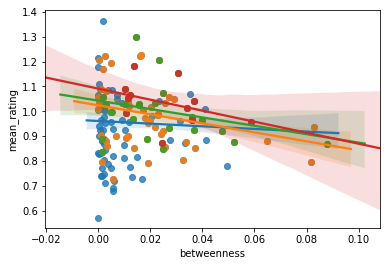

In [235]:
bet = []
b_p = []
clo = []
c_p = []
ind = []
deg = []
d_p = []
for i in range(2, 10, 2):
    df2 = df[df['camps_played'] >= i]
    _, _, _, b_p_value, _ = scipy.stats.linregress(df2["betweenness"], df2["mean_rating"])
    _, _, _, c_p_value, _ = scipy.stats.linregress(df2["closeness"], df2["mean_rating"])
    _, _, _, d_p_value, _ = scipy.stats.linregress(df2["degree"], df2["mean_rating"])
    
    bet.append(df2["betweenness"].corr(df2["mean_rating"]))
    clo.append(df2["closeness"].corr(df2["mean_rating"]))
    deg.append(df2["degree"].corr(df2["mean_rating"]))
    
    b_p.append(round(b_p_value,4))
    c_p.append(round(c_p_value,4))
    d_p.append(round(d_p_value,4))
    ind.append(i)
    sns.regplot(x="betweenness", y="mean_rating", data=df2);

In [236]:
res = pd.DataFrame({'betweenness':bet,'closeness':clo, 'camps_played':ind, 'closeness p-value': c_p, 'betweenness p-value': b_p, 'degree':deg, 'degree p-value' : d_p})
res

,betweenness,closeness,camps_played,closeness p-value,betweenness p-value,degree,degree p-value
0,-0.068358,0.279468,2,0.0006,0.4123,0.144388,0.0821
1,-0.290908,0.126306,4,0.2769,0.0108,-0.031542,0.7868
2,-0.297966,0.215718,6,0.2279,0.0921,0.132672,0.4617
3,-0.386024,-0.312303,8,0.3498,0.2410,-0.076102,0.8240


/home/martim/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



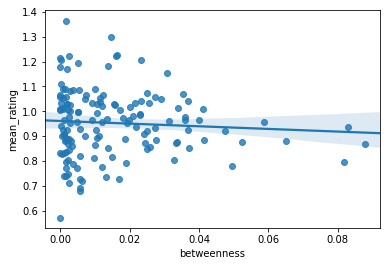

In [237]:
df2 = df[df['camps_played'] >= 2]
sns.regplot(x="betweenness", y="mean_rating", data=df2);

/home/martim/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



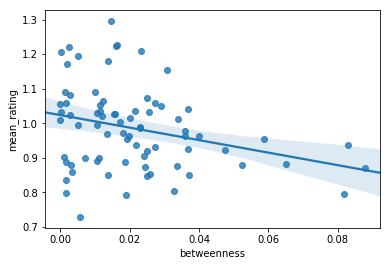

In [238]:
df4 = df[df['camps_played'] >= 4]
sns.regplot(x="betweenness", y="mean_rating", data=df4);

/home/martim/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



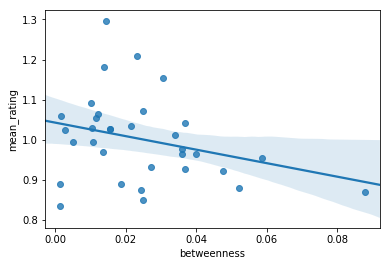

In [239]:
df6 = df[df['camps_played'] >= 6]
sns.regplot(x="betweenness", y="mean_rating", data=df6);

/home/martim/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



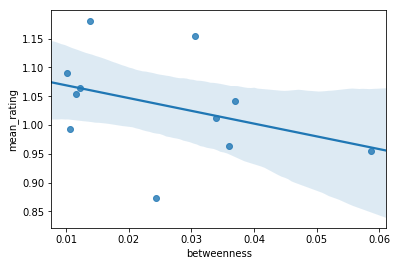

In [240]:
df8 = df[df['camps_played'] >= 8]
sns.regplot(x="betweenness", y="mean_rating", data=df8);